### Phát hiện đối tượng bằng YOLO v2

In [8]:
import tensorflow as tf
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.models import load_model
import os
import matplotlib.pylab as pylab
import numpy as np
from PIL import Image
import tensorflow.keras.backend as K
from yad2k.models.keras_yolo import yolo_head, yolo_eval
import colorsys
import random
from PIL import Image, ImageDraw, ImageFont

@register_keras_serializable()
def space_to_depth_x2(x):
    import tensorflow as tf
    return tf.nn.space_to_depth(x, block_size=2)

@register_keras_serializable()
def space_to_depth_x2_output_shape(input_shape):
    return (input_shape[0], input_shape[1] // 2, input_shape[2] // 2, 4 *
            input_shape[3]) if input_shape[1] else input_shape

In [9]:
def read_classes(classes_path):
    with open(classes_path) as f:
        class_names = f.readlines()
        class_names = [c.strip() for c in class_names]
    return class_names

def read_anchors(anchors_path):
    with open(anchors_path) as f:
        anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        anchors = np.array(anchors).reshape(-1, 2)
    return anchors

def generate_colors(class_names):
    hsv_tuples = [(x / len(class_names), 1., 1.) for x in
    range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))
    random.seed(10101) # Fixed seed for consistent colors across runs.
    random.shuffle(colors) # Shuffle colors to decorrelate adjacent classes.
    random.seed(None) # Reset seed to default.
    return colors

def scale_boxes(boxes, image_shape):
    """ scales the predicted boxes in order to be drawable on the image"""
    height = image_shape[0]
    width = image_shape[1]
    image_dims = K.stack([height, width, height, width])
    image_dims = K.reshape(image_dims, [1, 4])
    boxes = boxes * image_dims
    return boxes

In [10]:
def preprocess_image(img_path, model_image_size):
    image = Image.open(img_path)
    resized_image = image.resize(tuple(reversed(model_image_size)), Image.BICUBIC)
    image_data = np.array(resized_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0) # Add batch dimension.
    return image, image_data

def draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors):
    try:
        font = ImageFont.truetype("arial.ttf", size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    except OSError:
        # Fallback for Windows if arial.ttf not found
        font = ImageFont.load_default()
        
    thickness = (image.size[0] + image.size[1]) // 300

    for i, c in reversed(list(enumerate(out_classes))):
        predicted_class = class_names[c]
        box = out_boxes[i]
        score = out_scores[i]
        label = '{} {:.2f}'.format(predicted_class, score)
        
        draw = ImageDraw.Draw(image)
        
        # Use textbbox instead of textsize
        bbox = draw.textbbox((0, 0), label, font=font)
        label_size = (bbox[2] - bbox[0], bbox[3] - bbox[1])
        
        top, left, bottom, right = box
        top = max(0, np.floor(top).astype('int32'))
        left = max(0, np.floor(left).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom).astype('int32'))
        right = min(image.size[0], np.floor(right).astype('int32'))
        
        print(label, (left, top), (right, bottom))
        
        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])
            
        # Draw box
        for i in range(thickness):
            draw.rectangle([left + i, top + i, right - i, bottom - i], outline=colors[c])
        
        # Draw label background
        draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill=colors[c])
        
        # Draw label text
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw

In [11]:
# provide the name of the image that you saved in the images folder to be fed through the network
input_image_name = "cars.jpg"
input_image = Image.open("../images/" + input_image_name)
width, height = input_image.size
width = np.array(width, dtype=float)
height = np.array(height, dtype=float)
image_shape = (height, width)
class_names = read_classes("yolo/coco_classes.txt")    
anchors = read_anchors("yolo/yolo_anchors.txt")
custom_objects = {
    'space_to_depth_x2': space_to_depth_x2,
    'space_to_depth_x2_output_shape': space_to_depth_x2_output_shape
}

# Load model với custom objects
yolo_model = load_model("yolo/yolo.h5", custom_objects=custom_objects)
yolo_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 608, 608,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 608, 608,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 608, 608,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 608, 608,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 304, 304,  │          0 │ leaky_re_lu[0][0] │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 304, 304,  │     18,432 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 304, 304,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 304, 304,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 152, 152,  │          0 │ leaky_re_lu_1[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 152, 152,  │     73,728 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 152, 152,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 152, 152,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 152, 152,  │      8,192 │ leaky_re_lu_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 152, 152,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 152, 152,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 152, 152,  │     73,728 │ leaky_re_lu_3[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 152, 152,  │        512 │ conv2d_4[0][0]  

 Total params: 50,983,561 (194.49 MB)

 Trainable params: 50,962,889 (194.41 MB)

 Non-trainable params: 20,672 (80.75 KB)

In [12]:
print("Model input shape:", yolo_model.input_shape)
print("Model output shape:", yolo_model.output_shape)

Model input shape: (None, 608, 608, 3)
Model output shape: (None, 19, 19, 425)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Found 10 boxes for cars.jpg
car 0.28 (np.int32(263), np.int32(225)) (np.int32(305), np.int32(349))
truck 0.51 (np.int32(189), np.int32(89)) (np.int32(442), np.int32(237))
umbrella 0.61 (np.int32(203), np.int32(193)) (np.int32(304), np.int32(232))
car 0.62 (np.int32(272), np.int32(212)) (np.int32(322), np.int32(357))
car 0.64 (np.int32(503), np.int32(178)) (np.int32(677), np.int32(354))
car 0.72 (np.int32(33), np.int32(197)) (np.int32(221), np.int32(378))
person 0.75 (np.int32(188), np.int32(214)) (np.int32(290), np.int32(404))
bus 0.76 (np.int32(7), np.int32(90)) (np.int32(189), np.int32(389))
car 0.78 (np.int32(282), np.int32(179)) (np.int32(516), np.int32(367))
car 0.85 (np.int32(603), np.int32(226)) (np.int32(727), np.int32(374))


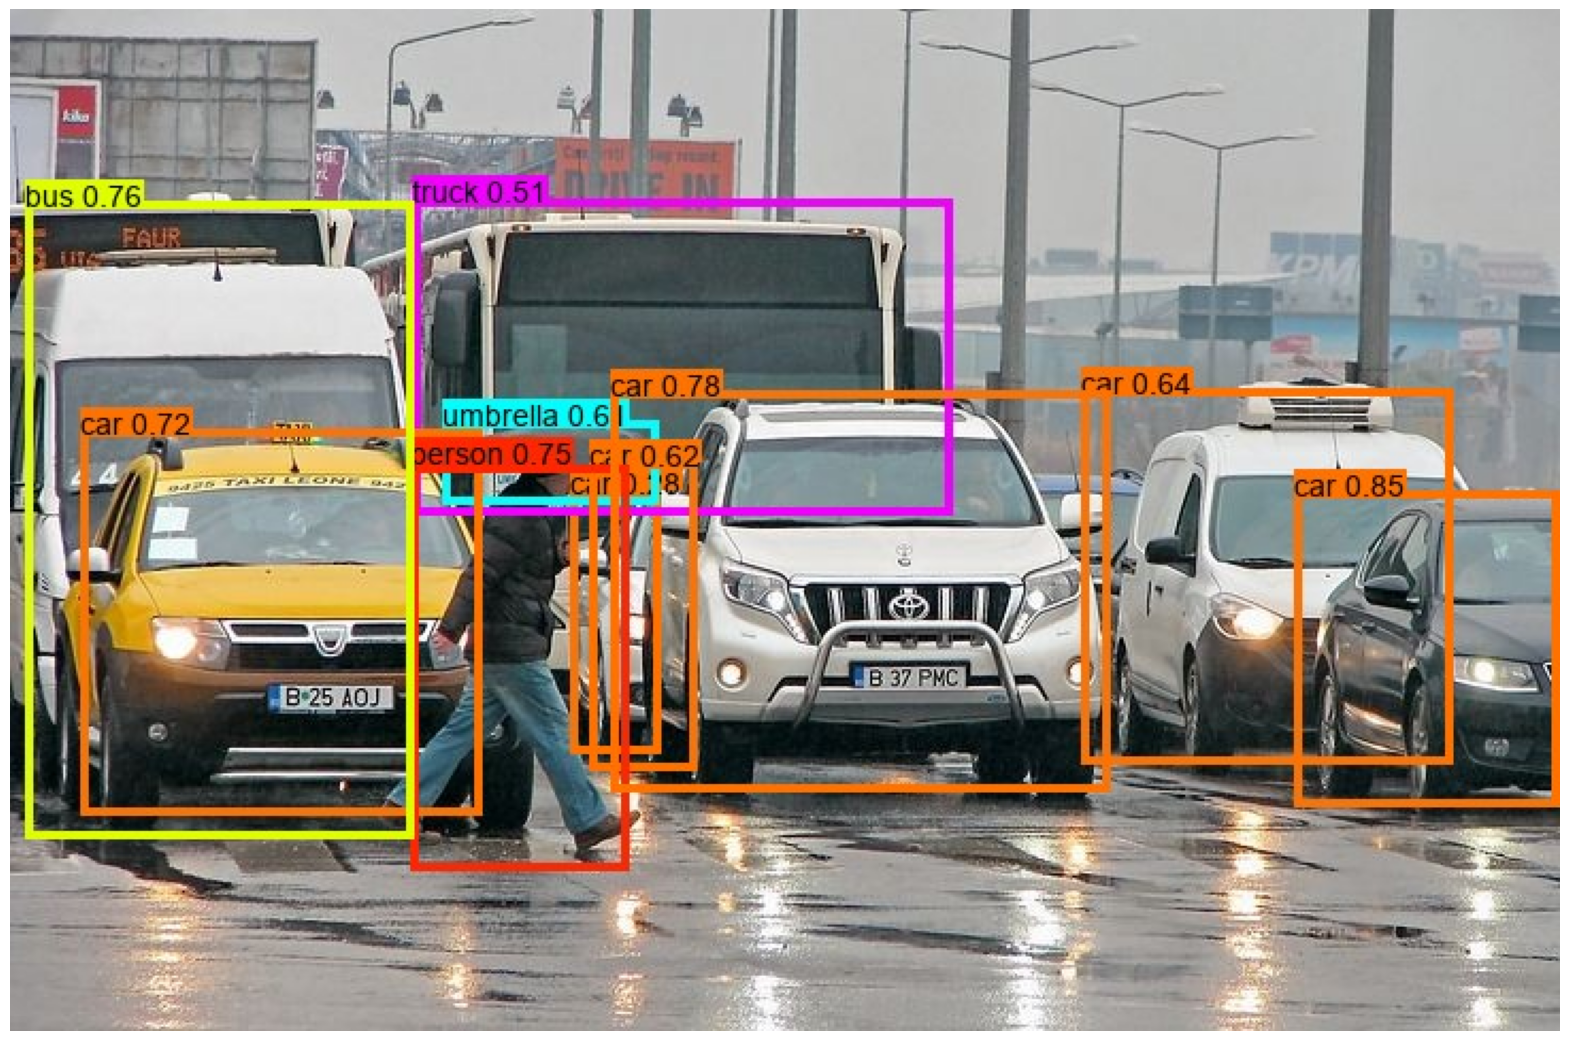

In [13]:
# 1. Preprocess image
image, image_data = preprocess_image("../images/" + input_image_name, model_image_size = (608, 608))

# 2. Get YOLO outputs
yolo_outputs = yolo_model.predict(image_data)
yolo_outputs = tf.convert_to_tensor(yolo_outputs, dtype=tf.float32)

# 3. Convert anchors to float32 tensor
anchors = tf.convert_to_tensor(anchors, dtype=tf.float32)

# 4. Convert features to box parameters 
box_xy, box_wh, box_confidence, box_class_probs = yolo_head(yolo_outputs, anchors, len(class_names))

# 5. Convert image shape
image_shape = tf.convert_to_tensor(image_shape, dtype=tf.float32)

# 6. Run evaluation với thêm tham số len(class_names)
boxes, scores, classes = yolo_eval(
    [box_xy, box_wh, box_confidence, box_class_probs],
    image_shape,
    len(class_names),  # Thêm tham số này
    max_boxes=10,
    score_threshold=.6,
    iou_threshold=.5
)

# 7. Convert outputs to numpy
out_boxes = boxes.numpy()
out_scores = scores.numpy()
out_classes = classes.numpy()

# 8. Print results and draw boxes
print('Found {} boxes for {}'.format(len(out_boxes), input_image_name))

colors = generate_colors(class_names)
draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)

# 9. Save and display
image.save(os.path.join("output", input_image_name), quality=90)

import imageio.v2 as imageio
output_image = imageio.imread(os.path.join("output", input_image_name))  # Thay đổi dòng này

pylab.figure(figsize=(20,20))
pylab.imshow(output_image)
pylab.axis('off')
pylab.show()

## Phân đoạn ngữ nghĩa với DeepLab V3+

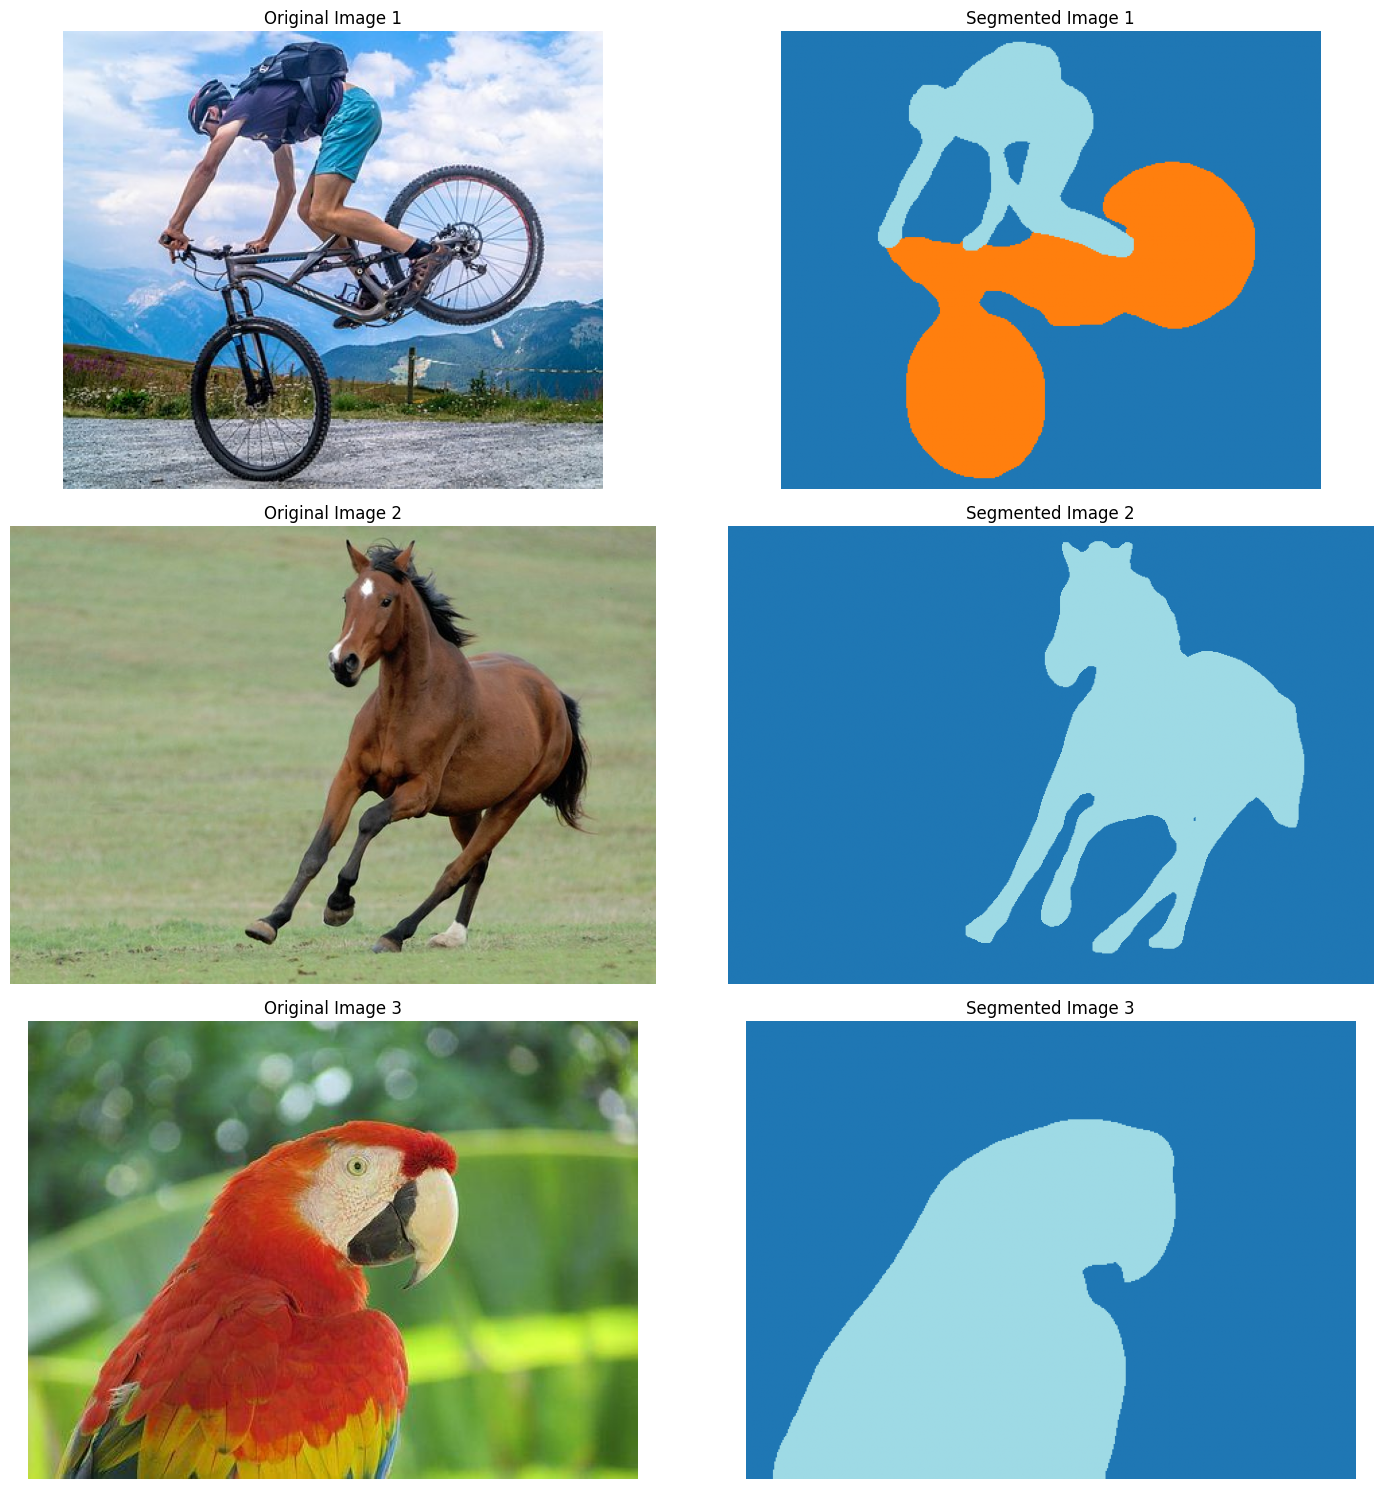

In [14]:
import torch  
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models
import cv2  # Thêm thư viện OpenCV để thực hiện Erosion và Dilation

# Khởi tạo mô hình DeepLabV3 với backbone ResNet-101
model = models.segmentation.deeplabv3_resnet101(weights="COCO_WITH_VOC_LABELS_V1").eval()

image_paths = ['../images/cycle.jpg', '../images/horse.jpg', '../images/parrot.jpg']

# Tiền xử lý ảnh
preprocess = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

plt.figure(figsize=(15, 15))

for i, image_path in enumerate(image_paths):
    image = Image.open(image_path).convert("RGB")
    # Tiền xử lý ảnh
    input_tensor = preprocess(image).unsqueeze(0)  # Thêm batch dimension
    # Dự đoán phân đoạn
    with torch.no_grad():
        output = model(input_tensor)['out'][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()
    # Thực hiện Erosion và Dilation để cải thiện biên phân đoạn
    kernel = np.ones((5, 5), np.uint8)
    output_predictions = cv2.erode(output_predictions, kernel, iterations=1)  # Erosion
    output_predictions = cv2.dilate(output_predictions, kernel, iterations=1)  # Dilation
    # Dùng colormap mặc định của Matplotlib (ví dụ 'tab20' hoặc 'jet')
    num_classes = output_predictions.max() + 1  # Số lớp tối đa trong dự đoán
    colormap = plt.get_cmap('tab20', num_classes)  # Dùng colormap 'tab20'
    segmented_image = colormap(output_predictions / num_classes)  # Chia lại giá trị phân đoạn để phù hợp với colormap

    plt.subplot(3, 2, 2*i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Original Image {i+1}")
    plt.subplot(3, 2, 2*i+2)
    plt.imshow(segmented_image)
    plt.axis("off")
    plt.title(f"Segmented Image {i+1}")
plt.tight_layout()
plt.show()